In [55]:
# Importing necessary dependencies
DRAFT = True
import itertools
import logging
import warnings
import numpy as np
print(np.version.version)
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings("ignore", "plotnine\..*")

import cmdstanpy as csp
csp.utils.get_logger().setLevel(logging.ERROR)


import statistics as stat
import pandas as pd
import plotnine as pn
import patchworklib as pw


# This works with printing instead of drawing: https://lightrun.com/answers/spyder-ide-spyder-plotnine-plots-not-showing-up
def mydraw(x):
    """draw plot in the quarto doc"""
    #x.draw()
    print(x)

1.23.1


In [20]:
f = open('binomial-rng.stan', 'w')
f.write("""

data {
    int<lower=0> N;
    real<lower=0, upper=1> theta;
}
generated quantities{
    int<lower=0, upper=N> y = binomial_rng(N, theta);
}

""")
f.close()

In [57]:
# Drawing 10 samples from the first model
N = 100
theta = 0.3
data = {'N': N, 'theta': theta}
model = csp.CmdStanModel(stan_file = 'binomial-rng.stan')
sample = model.sample(data = data, seed = 123, chains = 1, 
                      iter_sampling = 10, iter_warmup = 0, 
                      show_progress = True, show_console = True)

Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 10
Chain [1] num_warmup = 0
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\manny\AppData\Local\Temp\tmp2um06olm\148c_fd9.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1]   seed = 123
Chain [1] output


In [58]:
# Number of clinical trial successes with 10 samples consisting of 100 patients and a 30% probability of success
y = sample.stan_variable('y')
print("N = ", N, "; theta = ", theta, "; y(0:10) = ", *y.astype(int))

N =  100 ; theta =  0.3 ; y(0:10) =  33 36 30 28 37 26 25 19 29 33


In [59]:
# Running a looped version of the above scenario
for N in [10, 100, 1_000, 10_000]:
    data = {'N': N, 'theta': theta}
    sample = model.sample(data = data, seed = 123, chains = 1,
                          iter_sampling = 10, iter_warmup = 0,
                          show_progress = False,
              show_console = False)
    y = sample.stan_variable('y')
    print("N =", N)
    print("  y: ", *y.astype(int))
    print("  est. theta: ", *(y / N))

N = 10
  y:  4 4 3 4 3 3 3 5 2 4
  est. theta:  0.4 0.4 0.3 0.4 0.3 0.3 0.3 0.5 0.2 0.4
N = 100
  y:  33 36 30 28 37 26 25 19 29 33
  est. theta:  0.33 0.36 0.3 0.28 0.37 0.26 0.25 0.19 0.29 0.33
N = 1000
  y:  322 324 306 333 311 318 294 323 282 311
  est. theta:  0.322 0.324 0.306 0.333 0.311 0.318 0.294 0.323 0.282 0.311
N = 10000
  y:  3049 3052 3012 3025 3042 3087 3051 2922 2943 3025
  est. theta:  0.3049 0.3052 0.3012 0.3025 0.3042 0.3087 0.3051 0.2922 0.2943 0.3025


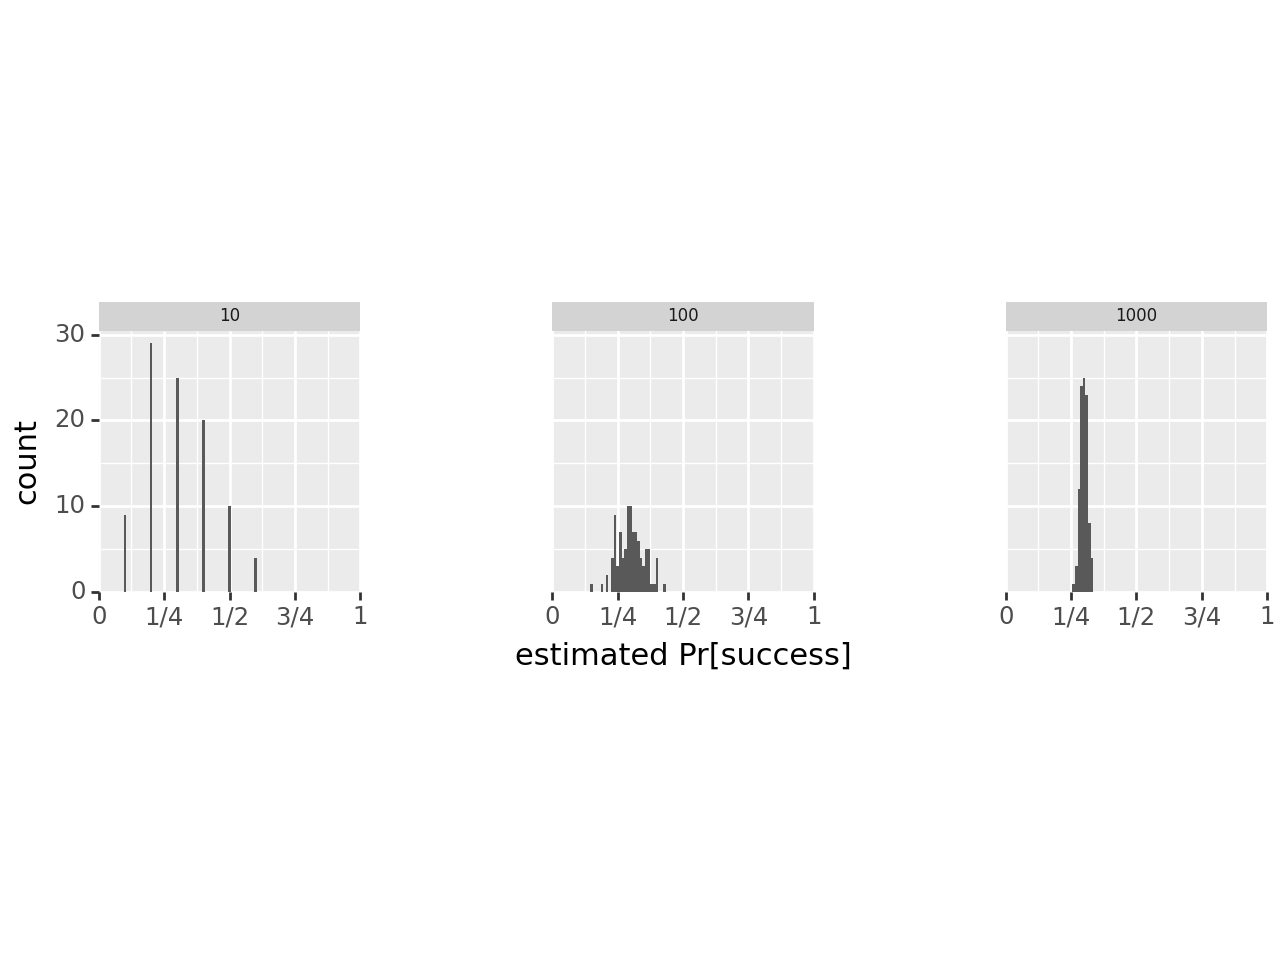

In [60]:
# Plotting for different sizes of N, and for 100,000 values of y

np.random.seed(123)
ts = []
ps = []
theta = 0.3
M = 100 if DRAFT else 100000
for N in [10, 100, 1000]:
    data = {'N': N, 'theta': theta}
    sample = model.sample(data = data, seed = 123, chains = 1, iter_sampling = M, iter_warmup = 0, 
                          show_progress = False, show_console = False)
    y = sample.stan_variable('y')
    theta_hat = y/N
    ps.extend(theta_hat)
    ts.extend(itertools.repeat(N, M))
xlabel = 'estimated Pr[success]'
df = pd.DataFrame({xlabel: ps, 'trials': ts})

# I used print here instead of draw? Interesting
mydraw(pn.ggplot(df, pn.aes(x = xlabel))
       + pn.geom_histogram(binwidth = 0.01)
       + pn.facet_grid('. ~ trials')
       + pn.scales.scale_x_continuous(limits = [0,1], breaks = [0, 1/4, 1/2, 3/4, 1],
                                     labels = ["0", "1/4", "1/2", "3/4", "1"], expand = [0, 0])
       + pn.scales.scale_y_continuous(expand = [0, 0, 0.05, 0])
       + pn.theme(aspect_ratio = 1, panel_spacing = 0.15,
                 strip_text = pn.element_text(size = 6),
                 strip_background = pn.element_rect(height = 0.08,
                                                   fill = "lightgray")))

In [47]:
# Stan generates based on a random seed

for seed in [123, 19876, 123]:
    sample = model.sample(data = data, seed = seed, chains = 1,
                         iter_sampling = 10, iter_warmup = 0,
                         show_progress = False, show_console = False)
    print(f"{seed = }; sample = {np.asarray(sample.stan_variable('y'), dtype = 'int')}")

seed = 123; sample = [322 324 306 333 311 318 294 323 282 311]
seed = 19876; sample = [286 303 286 309 289 276 317 298 328 294]
seed = 123; sample = [322 324 306 333 311 318 294 323 282 311]


In [48]:
# Creating a Stan document for monte carlo pi estimation

f = open('monte-carlo-pi.stan', 'w')
f.write("""

generated quantities{
    real<lower = -1, upper = 1> x = uniform_rng(-1, 1);
    real<lower = -1, upper = 1> y = uniform_rng(-1, 1);
    int<lower = 0, upper = 1> inside = x^2 + y^2 < 1;
    real<lower = 0, upper = 4> pi = 4*inside;
}

""")
f.close()

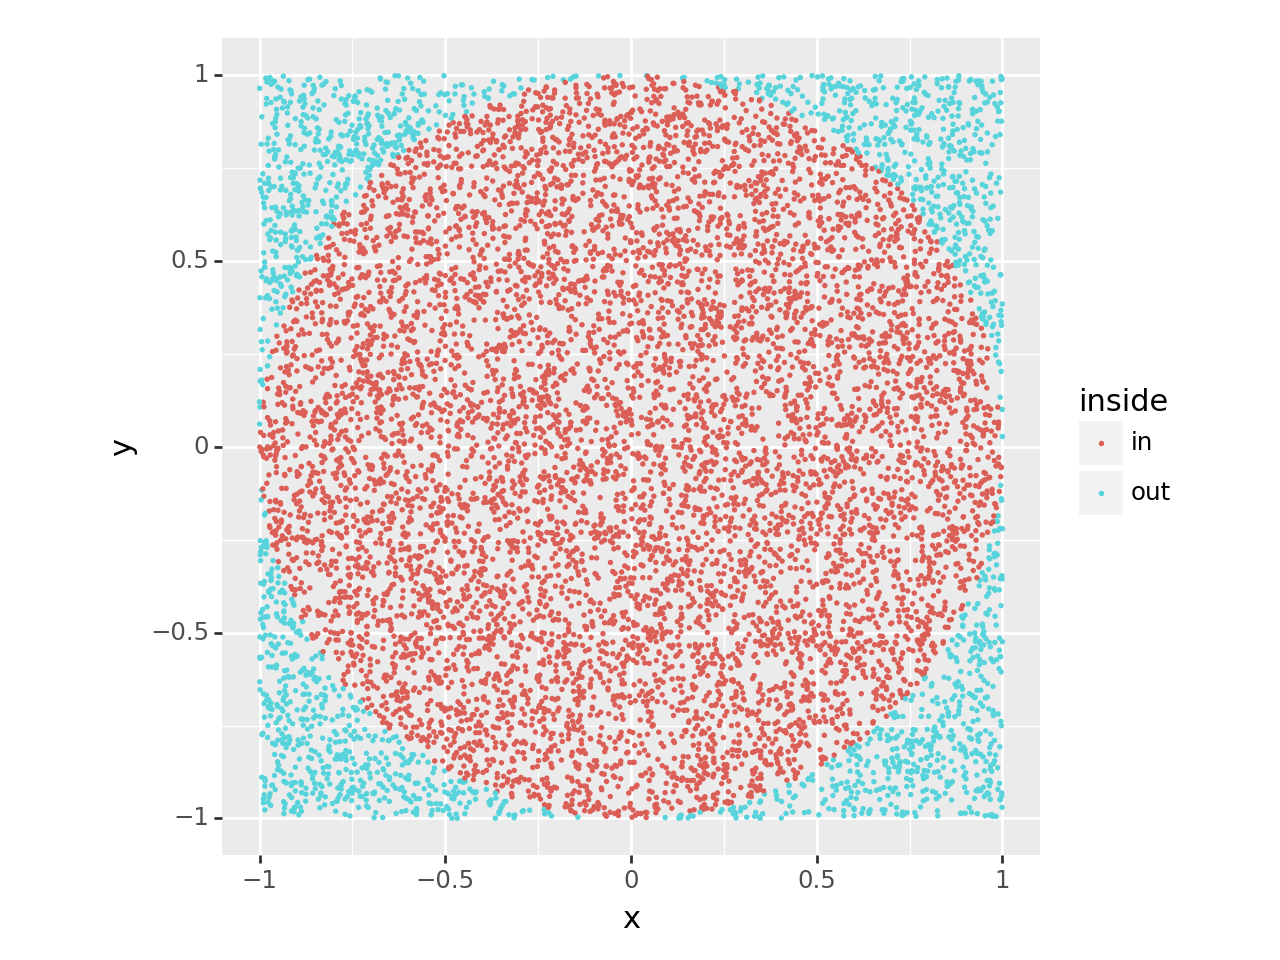

In [53]:
# Estiamting the area of pi with monte carlo 

M = 100 if DRAFT else 10_000
model = csp.CmdStanModel(stan_file = 'monte-carlo-pi.stan')
sample = model.sample(chains = 1, iter_warmup = 0, iter_sampling = M,
                      show_progress = False, show_console = False,
                      seed = 123)
x_draws = sample.stan_variable('x')
y_draws = sample.stan_variable('y')
inside_draws = [int(i) for i in sample.stan_variable('inside')]
pi_draws = sample.stan_variable('pi')
inside_named_draws = np.array(["out", "in"])[inside_draws]
df = pd.DataFrame({'x': x_draws, 'y': y_draws,
                   'inside': inside_named_draws})
mydraw(
  pn.ggplot(df, pn.aes(x = 'x', y = 'y',
                group='inside', color='inside'))
  + pn.geom_point(size = 0.1)
  + pn.labs(x = 'x', y = 'y')
  + pn.coord_fixed(ratio = 1)
)

In [62]:
# Esimate of pi 
P_inside = np.mean(inside_draws)
pi_hat = np.mean(pi_draws)
print(f"Pr[Y is inside circle] = {P_inside:.3f};")
print(f"estimate for pi = {pi_hat:.3f}")

Pr[Y is inside circle] = 0.786;
estimate for pi = 3.144


In [67]:
# Stan file for first MCMC

f = open('markov-autocorrelation.stan', 'w')
f.write("""

data {
    int<lower = 0> M;
    real<lower = 0, upper = 1> rho;
}

generated quantities{
    array[M] int<lower = 0, upper = 1> y;
    y[1] = bernoulli_rng(0.5);
    for (m in 2:M){
        y[m] = bernoulli_rng(y[m-1] ? rho: 1-rho);
    }
}

""")
f.close()

In [68]:
# Markov chain sumulated accorded to above

model = csp.CmdStanModel(stan_file = 'markov-autocorrelation.stan')
M = 100 if DRAFT else 1000
rhos = []
iterations = []
draws = []
estimates = []
for rho in [0.05, 0.5, 0.95]:
    data = {'M': M, 'rho': rho}
    sample = model.sample(data = data, seed = 123, chains = 1,
                      iter_warmup = 0, iter_sampling = 1,
                      show_progress = False, show_console = False)
    y_sim = sample.stan_variable('y')
    cum_sum = np.cumsum(y_sim)
    its = np.arange(1, M + 1)
    ests = cum_sum / its
    draws.extend(y_sim[0])
    iterations.extend(its)
    estimates.extend(ests)
    rhos.extend(itertools.repeat(str(rho), M))
df = pd.DataFrame({'draw': draws, 'iteration': iterations,
                   'estimate': estimates, 'rho': rhos})
rho05 = np.array(df.query('rho == "0.05"').head(100)['draw'], dtype = 'int')
rho50 = np.array(df.query('rho == "0.5"').head(100)['draw'], dtype = 'int')
rho95 = np.array(df.query('rho == "0.95"').head(100)['draw'], dtype = 'int')
print("Markov chain draw with probability rho of repeating last value:\n")
print("rho = 0.05:", rho05, "\n")
print("rho = 0.50:", rho50, "\n")
print("rho = 0.95:", rho95, "\n")

Markov chain draw with probability rho of repeating last value:

rho = 0.05: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1] 

rho = 0.50: [0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0
 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0] 

rho = 0.95: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0] 



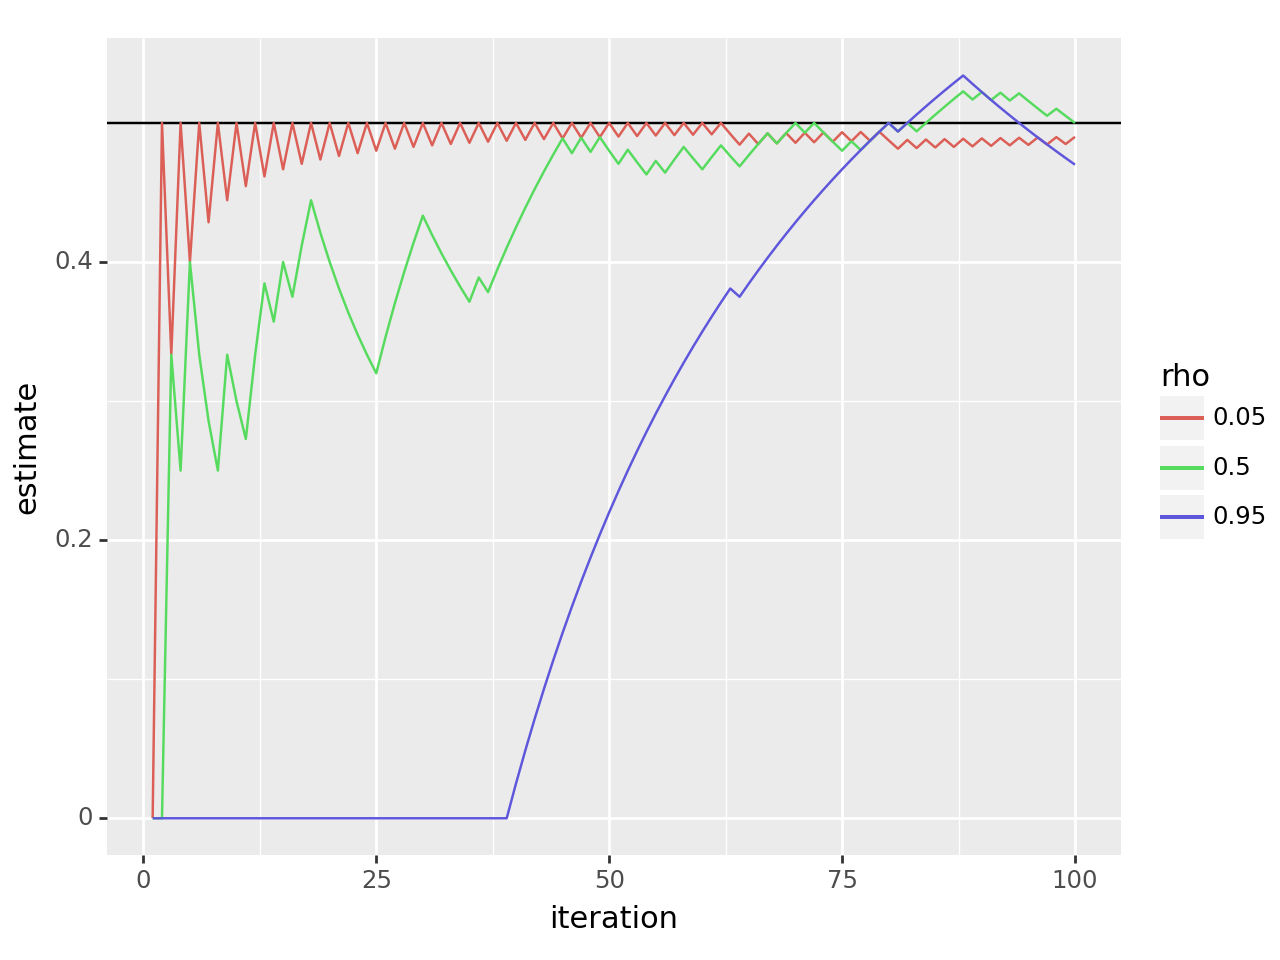

In [71]:
mydraw(
    pn.ggplot(df, pn.aes(x='iteration', y='estimate',
                  group='rho', color='rho'))
    + pn.geom_hline(yintercept = 0.5, color = 'black')        
    + pn.geom_line()
    + pn.labs(x = "iteration", y = "estimate")
)

In [ ]:
# It is more efficent to iterate by column than by row in Stan
# Stan is 1-indexed
# Stan loops are inclusive